In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn(batch_size, sequence_length, input_dim)

In [3]:
x.size()

torch.Size([1, 4, 512])

In [4]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [5]:
qkv = qkv_layer(x)

In [6]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

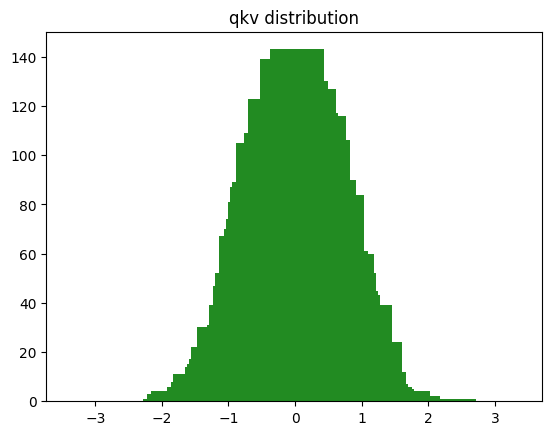

In [7]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01)*3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [11]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [17]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [18]:
qkv = qkv.permute(0, 2, 1, 3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [19]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [21]:
import math
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [22]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [23]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[-1.0541,  0.4899],
        [-0.1509, -0.9026],
        [ 0.8793, -1.0266]])

In [25]:
torch.transpose(y, 1, 0)

tensor([[-1.0541,  0.4899],
        [-0.1509, -0.9026],
        [ 0.8793, -1.0266]])

In [28]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [26]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [27]:
(scaled + mask)[0][0]

tensor([[-0.0466,    -inf,    -inf,    -inf],
        [ 0.1995, -0.0161,    -inf,    -inf],
        [ 0.7952, -0.1375,  0.0429,    -inf],
        [-0.0550, -0.5064, -0.3362, -0.0524]], grad_fn=<SelectBackward0>)

In [29]:
scaled += mask

In [30]:
attention = F.softmax(scaled, dim=-1)

In [31]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5537, 0.4463, 0.0000, 0.0000],
        [0.5363, 0.2110, 0.2527, 0.0000],
        [0.2946, 0.1876, 0.2224, 0.2954]], grad_fn=<SelectBackward0>)

In [32]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

In [33]:
import math

def scaled_dot_product(q, k, v, mask=None):
  d_k = q.size()[-1]
  scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
  if mask is not None:
    scaled += mask
  attention = F.softmax(scaled, dim=-1)
  values = torch.matmul(attention, v)
  return values, attention

In [36]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [37]:
attention.shape

torch.Size([1, 8, 4, 4])

In [38]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5537, 0.4463, 0.0000, 0.0000],
        [0.5363, 0.2110, 0.2527, 0.0000],
        [0.2946, 0.1876, 0.2224, 0.2954]], grad_fn=<SelectBackward0>)

In [39]:
values.size()

torch.Size([1, 8, 4, 64])

In [40]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [41]:
linear_layer = nn.Linear(d_model, d_model)

In [42]:
out = linear_layer(values)

In [43]:
out.shape

torch.Size([1, 4, 512])

In [ ]:
out

In [49]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention


class MultiheadAttention(nn.Module):
   
   def __init__(self, input_dim, d_model, num_heads):
      super().__init__()
      self.input_dim = input_dim
      self.d_model = d_model
      self.num_heads = num_heads
      self.head_dim = d_model // num_heads
      self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
      self.linear_layer = nn.Linear(d_model, d_model)

   def forward(self, x, mask=None):
     batch_size, sequence_length, input_dim = x.size()
     print(f"x.size(): {x.size()}")
     qkv = self.qkv_layer(x)
     print(f"qkv.size(): {qkv.size()}")
     qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
     print(f"qkv.size(): {qkv.size()}")
     qkv = qkv.permute(0, 2, 1, 3)
     print(f"qkv.size(): {qkv.size()}")
     q, k, v = qkv.chunk(3, dim=-1)
     print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
     values, attention = scaled_dot_product(q, k, v, mask)
     print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
     values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
     print(f"values.size(): {values.size()}")
     out = self.linear_layer(values)
     print(f"out.size(): {out.size()}")
     return out


In [50]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )
model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)


x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
